In [11]:
import scipy.io as sio
import pandas as pd
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import seaborn as sns
import mne

In [2]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [3]:
P300_result=np.array(['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','1','2','3','4','5','6','7','8','9','0']).reshape(6,6)
P300_Result=pd.DataFrame([P300_result][0])

In [5]:
Data=[]
for i in range(8):
    label_indexs=[]
    file='Data/A0'+str(i+1)+'.mat'
    A0X = sio.loadmat(file,squeeze_me=True)
    df=pd.DataFrame(A0X['data']['X'].tolist(),columns=A0X['data']['channels'].tolist().tolist())
    df['y_stim']=A0X['data']['y_stim'].tolist().tolist()
    df['P300']=A0X['data']['y'].tolist().tolist()
    active_indexs=df[df.y_stim!=0].index.tolist()[::32]
    target_x,notarget_x=[],[]
    order_input,col_and_rows,ground_true=[],[],[]
    begin_index,end_index=40,120
    #sub_sample=20
    #sub_sample_index=int((end_index-begin_index)/20)
    for index in active_indexs:
        values=df.iloc[index+begin_index:index+end_index,:8].values
        values=(values-np.mean(values,axis=0))[np.newaxis]
        #values=signal.filtfilt(b, a, values,axis=0)[np.newaxis,::sub_sample_index]
        order_input.append(values)
        col_and_rows.append(df.iloc[index].y_stim)
        if df.iloc[index]['P300']==1:
            notarget_x.append(values)
            label_indexs.append(0)
        else:
            target_x.append(values)
            label_indexs.append(1)
            ground_true.append(df.iloc[index].y_stim)
    notarget_x=np.concatenate(notarget_x,axis=0)
    target_x=np.concatenate(target_x,axis=0)
    order_input=np.concatenate(order_input,axis=0)
    col_and_rows=np.array(col_and_rows)
    ground_true=np.array(ground_true)
    ground_col_and_rows=ground_true.reshape(-1,2).astype(int)
    P300_Result.index=np.arange(1,7)
    P300_Result.columns=np.arange(7,13)
    Ground_true=[ P300_Result[y][x] for (x,y) in ground_col_and_rows.tolist()]
    order_input=order_input.reshape(len(order_input),-1)
    Data.append([label_indexs,order_input.reshape(len(order_input),-1)])

In [6]:
order_output=[]
acc_train=[[] for x in range(8)]
acc_test=[[] for x in range(8)]
models=[[] for x in range(8)]
for user in range(8):
    print(user)
    X_train, X_test, y_train, y_test = Data[user][1][:25*10*12], Data[user][1][25*10*12:],Data[user][0][:25*10*12], Data[user][0][25*10*12:]
    h = .02  # step size in the mesh
    names = ["Linear Discriminant Analysis","Nearest Neighbors", "Linear SVM", "RBF SVM",
             "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
             "Naive Bayes"]
    classifiers = [
        LinearDiscriminantAnalysis(),
        KNeighborsClassifier(3),
        SVC(kernel="linear", C=0.025),
        SVC(gamma=2, C=1),
        DecisionTreeClassifier(max_depth=5),
        RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
        MLPClassifier(alpha=1, max_iter=500),
        AdaBoostClassifier(),
        GaussianNB(),]
    acc,classifier=[],[]
    for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        models[user].append(clf)
        Train_pred=clf.predict(X_train)
        Test_pred=clf.predict(X_test)
        confusion=confusion_matrix(y_train,Train_pred)/np.sum(confusion_matrix(y_train,Train_pred))
        print('model:%s  train accuarcy: %.2f'%(name,np.sum(np.diag(confusion))))
        acc_train[user].append(np.sum(np.diag(confusion)))
        confusion=confusion_matrix(y_test,Test_pred)/np.sum(confusion_matrix(y_test,Test_pred))
        acc_test[user].append(np.sum(np.diag(confusion)))
        print('model:%s  test accuarcy: %.2f'%(name,np.sum(np.diag(confusion))))

0
model:Linear Discriminant Analysis  train accuarcy: 0.87
model:Linear Discriminant Analysis  test accuarcy: 0.83
model:Nearest Neighbors  train accuarcy: 0.87
model:Nearest Neighbors  test accuarcy: 0.78
model:Linear SVM  train accuarcy: 0.86
model:Linear SVM  test accuarcy: 0.85
model:RBF SVM  train accuarcy: 1.00
model:RBF SVM  test accuarcy: 0.83
model:Decision Tree  train accuarcy: 0.84
model:Decision Tree  test accuarcy: 0.83
model:Random Forest  train accuarcy: 0.83
model:Random Forest  test accuarcy: 0.83
model:Neural Net  train accuarcy: 0.96
model:Neural Net  test accuarcy: 0.79
model:AdaBoost  train accuarcy: 0.85
model:AdaBoost  test accuarcy: 0.82
model:Naive Bayes  train accuarcy: 0.63
model:Naive Bayes  test accuarcy: 0.58
1
model:Linear Discriminant Analysis  train accuarcy: 0.88
model:Linear Discriminant Analysis  test accuarcy: 0.84
model:Nearest Neighbors  train accuarcy: 0.88
model:Nearest Neighbors  test accuarcy: 0.81
model:Linear SVM  train accuarcy: 0.86
model:

In [24]:
acc_train=pd.DataFrame(acc_train).T
acc_train.index= ["Linear Discriminant Analysis","Nearest Neighbors", "Linear SVM", "RBF SVM",
             "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
             "Naive Bayes"]
acc_train.columns=['User '+str(i+1) for i in range(8)]

In [25]:
acc_train

,User 1,User 2,User 3,User 4,User 5,User 6,User 7,User 8
Linear Discriminant Analysis,0.871667,0.877000,0.901667,0.872000,0.883333,0.897667,0.890000,0.920333
Nearest Neighbors,0.867333,0.882000,0.866333,0.866000,0.866000,0.873333,0.879333,0.890667
Linear SVM,0.860667,0.861667,0.893000,0.859000,0.870667,0.891333,0.882667,0.913667
RBF SVM,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Decision Tree,0.842333,0.858333,0.858667,0.865667,0.850333,0.861333,0.855000,0.874333
Random Forest,0.833667,0.835000,0.833667,0.833333,0.834000,0.833667,0.833333,0.833667
Neural Net,0.962000,0.997000,0.988333,0.987667,0.989333,0.987667,0.979667,0.996333
AdaBoost,0.849667,0.860667,0.867333,0.861667,0.843667,0.871667,0.865333,0.890333
Naive Bayes,0.632000,0.623000,0.656333,0.609333,0.615000,0.656000,0.616667,0.719000


In [22]:
test_acc=pd.DataFrame(acc_test).T
test_acc.index= ["Linear Discriminant Analysis","Nearest Neighbors", "Linear SVM", "RBF SVM",
             "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
             "Naive Bayes"]
test_acc.columns=['User '+str(i+1) for i in range(8)]

In [23]:
test_acc

,User 1,User 2,User 3,User 4,User 5,User 6,User 7,User 8
Linear Discriminant Analysis,0.825833,0.840833,0.831667,0.822500,0.819167,0.842500,0.883333,0.890833
Nearest Neighbors,0.780000,0.812500,0.783333,0.799167,0.802500,0.787500,0.810000,0.797500
Linear SVM,0.846667,0.852500,0.838333,0.847500,0.830000,0.855833,0.884167,0.885833
RBF SVM,0.833333,0.833333,0.833333,0.833333,0.833333,0.833333,0.833333,0.833333
Decision Tree,0.829167,0.849167,0.804167,0.800833,0.825000,0.805833,0.834167,0.823333
Random Forest,0.833333,0.832500,0.833333,0.833333,0.833333,0.833333,0.833333,0.833333
Neural Net,0.792500,0.801667,0.801667,0.794167,0.795833,0.824167,0.815833,0.846667
AdaBoost,0.822500,0.844167,0.826667,0.820833,0.826667,0.822500,0.839167,0.858333
Naive Bayes,0.583333,0.596667,0.651667,0.639167,0.608333,0.635000,0.650000,0.720000


In [60]:
diff_=[]
label_index=np.array(Data[0][0])
for i in range(8):
    p300_index=np.unique(np.arange(4200)*label_index)[1:]
    nop300_index=np.unique(np.arange(4200)*(1-label_index))
    nop300=Data[i][1][nop300_index].reshape(-1,10,80,8)
    p300=Data[i][1][p300_index].reshape(-1,2,80,8)
    diff=[]
    for i in range(p300.shape[0]):
        p300_signal=p300[i]
        nop300_signal=nop300[i]
        for v in range(2):
            x=np.mean(p300_signal[v]-p300_signal[v,0],axis=0)
            y=np.mean(nop300_signal[v]-nop300_signal[v,0],axis=0)
            diff.append(np.abs(x-y)[np.newaxis])
    diff=np.concatenate(diff)
    diff_.append(diff)

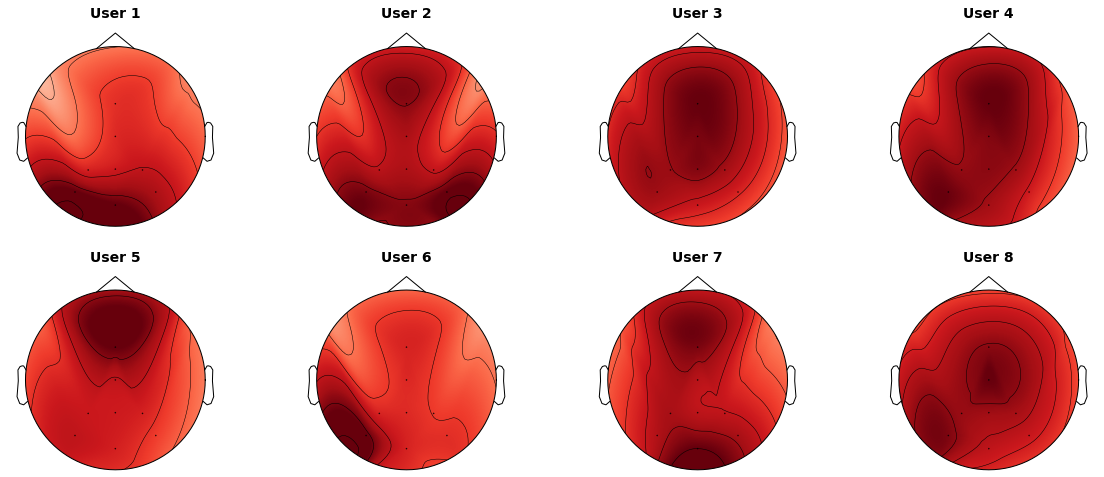

In [61]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 8), gridspec_kw=dict(top=0.9),
                       sharex=True, sharey=True)

#设置通道名
biosemi_montage = mne.channels.make_standard_montage('biosemi64')
#生成数据
data = np.mean(diff,axis=0).reshape(-1,1)
#创建info对象
info = mne.create_info(ch_names= A0X['data']['channels'].tolist().tolist(), sfreq=256.,
                            ch_types='eeg')
#创建evokeds对象                       
evoked = mne.EvokedArray(data, info)
#evokeds设置通道
evoked.set_montage(biosemi_montage)

# add titles
for i in range(8):
    x,y=int(i/4),i%4
    names='User '+str(i+1)
    mne.viz.plot_topomap(np.mean(diff_[i],axis=0), evoked.info, axes=ax[x,y],show=False)
    ax[x,y].set_title(names, fontweight='bold',fontsize=14)

In [68]:
test,accuracy=[],[]
for user in range(8):
    order_output=models[user][7].predict(Data[user][1])
    order_output=order_output.reshape(-1,120)
    pred=pd.DataFrame(order_output,columns=col_and_rows.reshape(-1,120)[0].astype(int))
    votting=[]
    for i in range(pred.shape[0]):
        vot=[[] for x in range(12)]
        for x in range(12):vot[x]=0
        #print(pred.iloc[i].values)
        for x,y in zip(pred.iloc[i].values,pred.iloc[i].index):
            if x==1:vot[y-1]+=1
        votting.append(vot)
    votting=pd.DataFrame(votting)
    rows,cols=np.argmax(votting.values[:,:6],axis=1).tolist(),np.argmax(votting.values[:,6:],axis=1).tolist()
    count,prediction=0,[]
    for x,y,labels in zip(rows,cols,Ground_true[::10]):
        if P300_Result[y+7][x+1]==labels:count+=1
        #print(P300_Result[y+7][x+1],labels)
        prediction.append(P300_Result[y+7][x+1])
    confusion=confusion_matrix(prediction,Ground_true[::10])\
    /np.sum(confusion_matrix(prediction,Ground_true[::10]))
    accuracy.append(np.sum(np.diag(confusion)))
    print(np.sum(np.diag(confusion)))
    test.append(pd.DataFrame(confusion,columns=set(prediction+Ground_true[::10]),index=set(prediction+Ground_true[::10])))

0.4285714285714286
0.6857142857142857
0.7142857142857143
0.5142857142857142
0.34285714285714286
0.6857142857142857
0.8285714285714286
0.9142857142857144


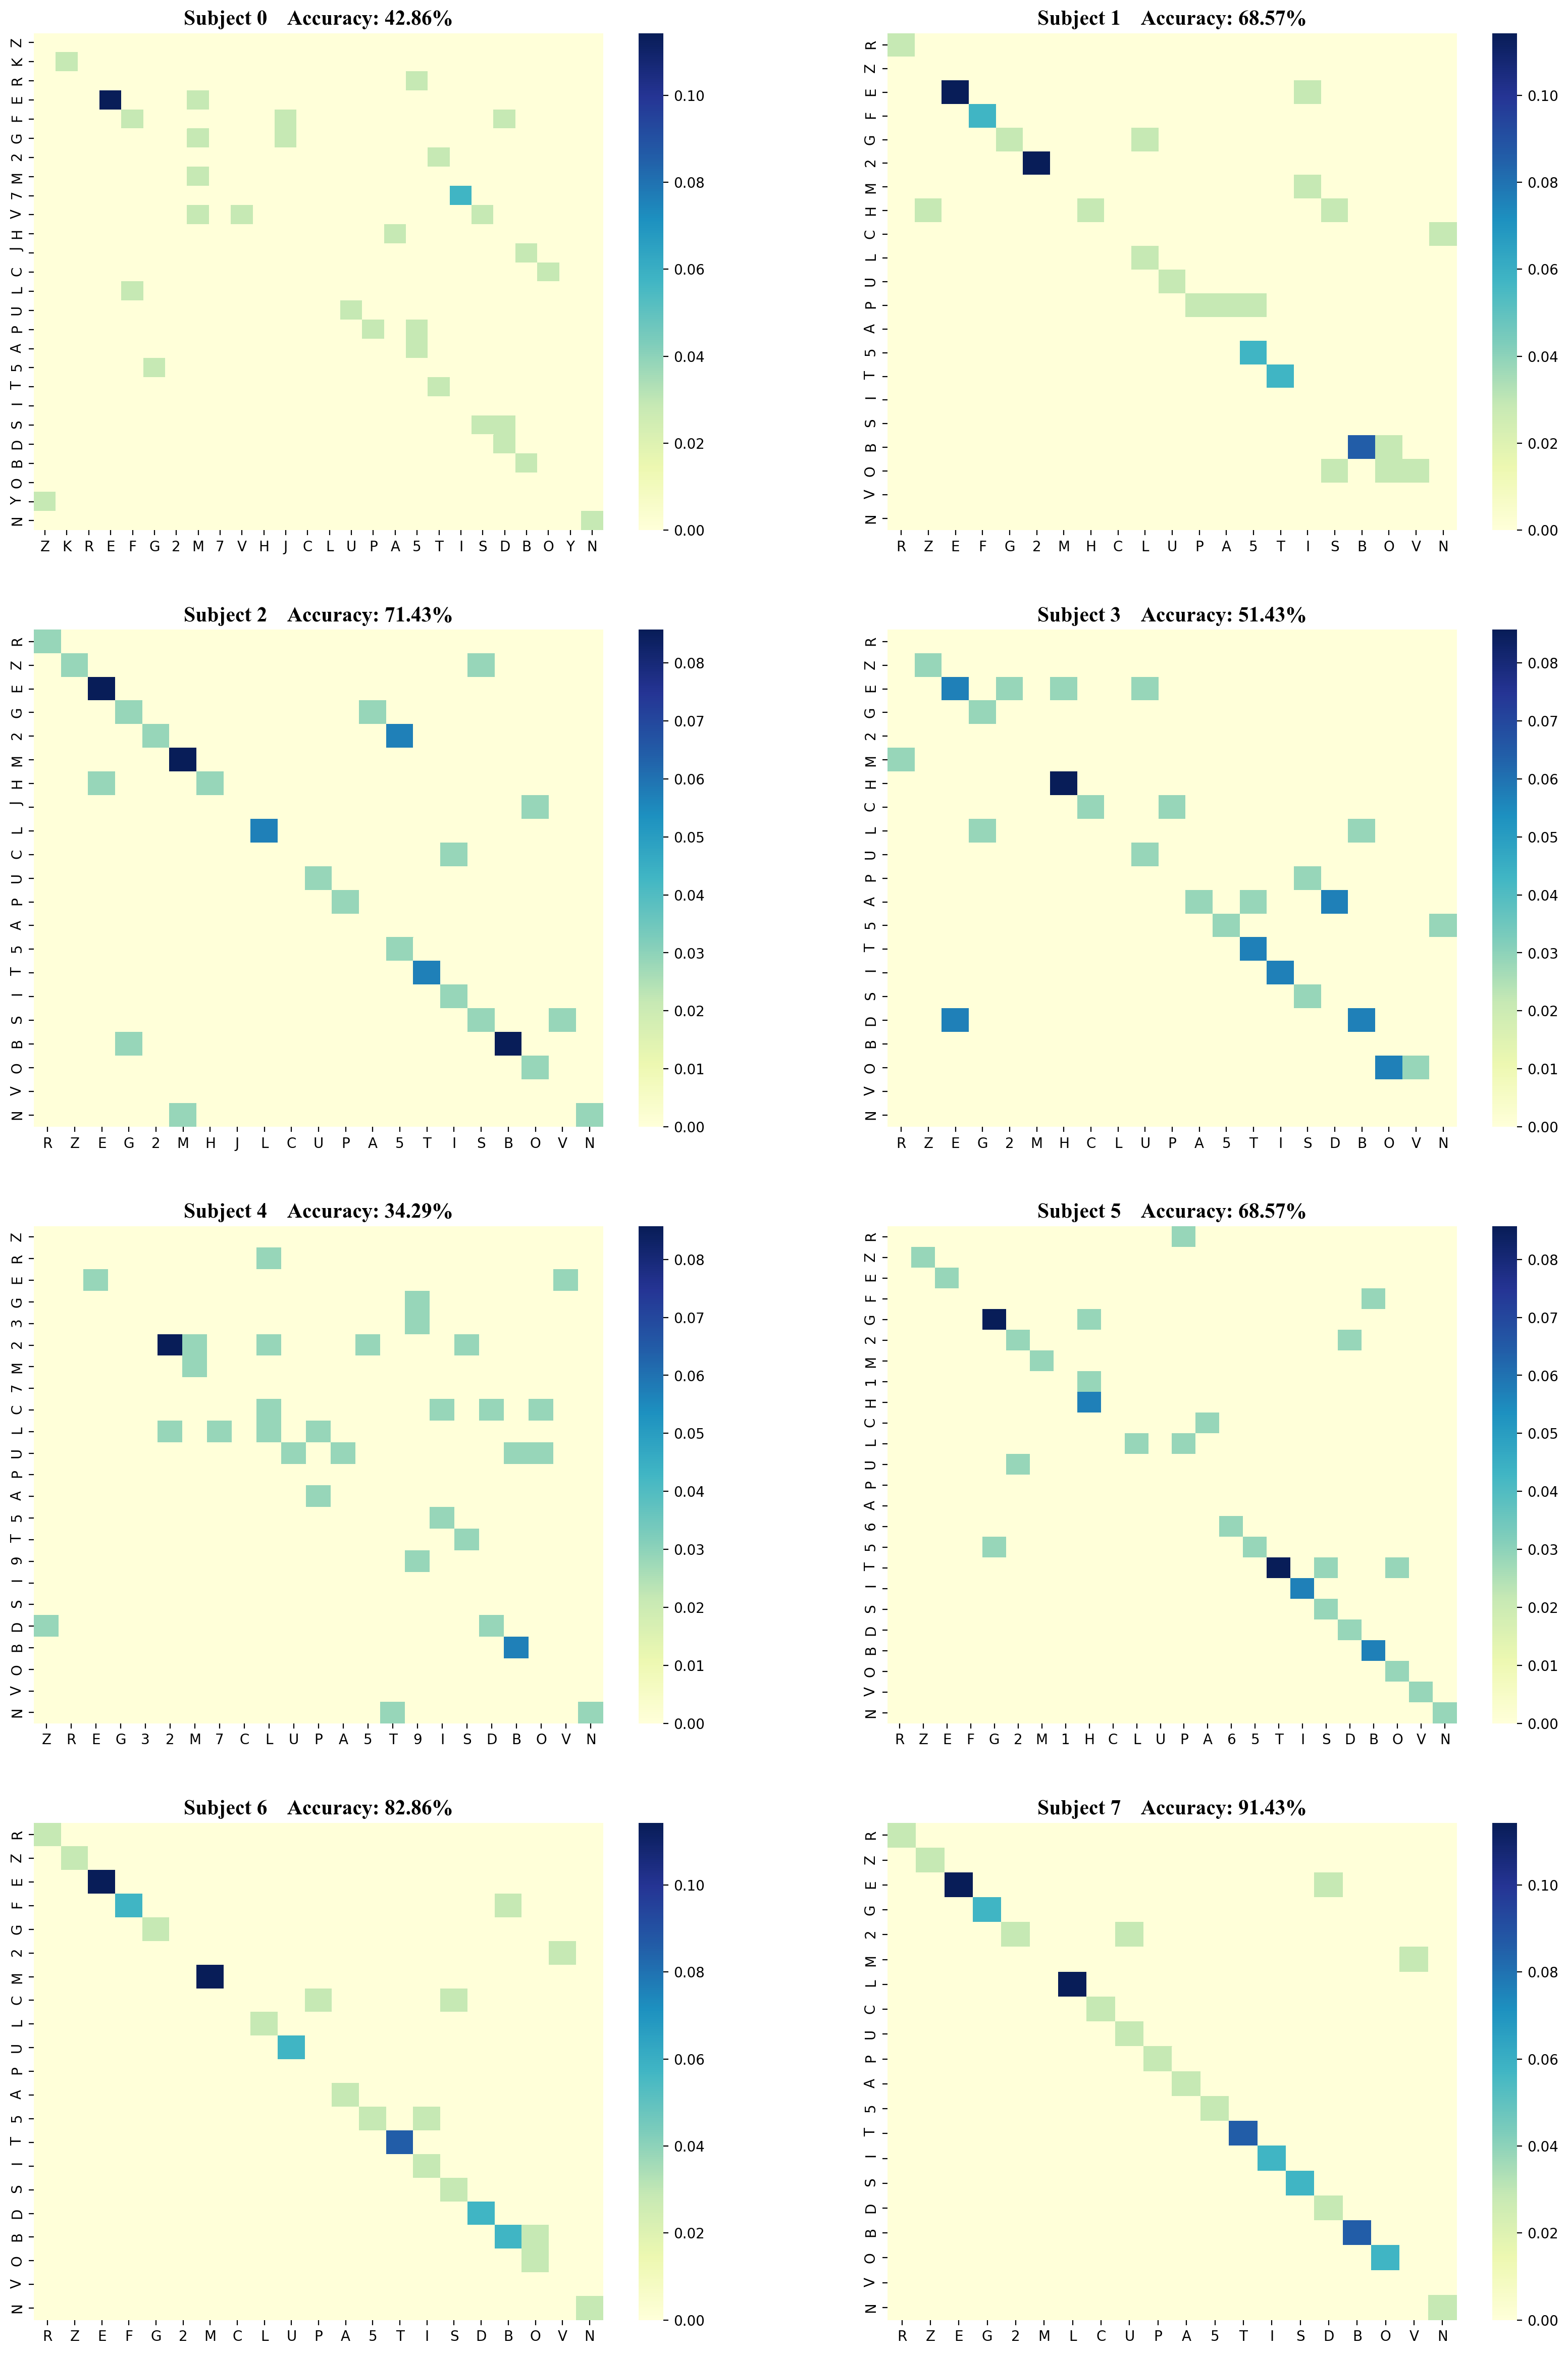

In [69]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(20, 30),dpi=200)
for i in range(8):
    x,y=int(i/2),i%2
    names='User '+str(i+1)
    sns.heatmap(test[i],ax=ax[x,y],cmap="YlGnBu",xticklabels=test[i].index)
    ax[x,y].set_title('Subject %.f    Accuracy: %.2f%%' %(i,accuracy[i]*100),family='Times New Roman',fontweight='bold',fontsize=15)

In [39]:
test[0]

,R,Z,E,G,2,M,L,C,U,P,A,5,T,I,S,D,B,O,V,N
R,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028571,0.000000
Z,0.000000,0.028571,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
E,0.000000,0.000000,0.114286,0.000000,0.000000,0.0,0.028571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028571,0.000000,0.000000,0.000000,0.000000
G,0.000000,0.000000,0.000000,0.057143,0.000000,0.0,0.028571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.028571,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028571,0.000000,0.000000
M,0.028571,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
L,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.057143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
C,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.028571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
U,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.057143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
P,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.028571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [43]:
history

import scipy.io as sio
import pandas as pd
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
P300_result=np.array(['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y